# Identify Fraudulent Activities
## Goal: 

Every day E-commerce websites often transact huge amount of money, however, no matter how careful we are, there are always risk that fraud could happen, such as using stolen credit cards, using other's account, etc. The goal of this challenge is to predict the probability that the first transaction of a new user is fraudulent via Machine Learning Models.
## Background Description:
Company XYZ is an e-commerce site that sells hand-made clothes.

Build a model that predicts whether a user has a high probability of using the site to preform some illegal activity or not. The information I have is about the user first transaction on the site and based on that you have to make your classification(fraud/no fraud).

Before dealing with the data, I listed several tasks that might guide me to solve the problem:
* For each user, determine his/her country based on the IP address
* BUild a model to predict whether an activity is fraudulent or not. Give a cost matrix of FP/FN with different values, and choose the best one, explain how it may impact the model.
* Explain to non-tech people how the model works as fraud detection. From a user prespective, what kinds of users are more likely to be classified as a risk? What are their characteristics?
* If the model can be used live to predict in real time whether a activity is fraud or not. Froma a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Dataset description:
There are 2 datasets:

**Fraud_data.csv** about each user first transaction,

**IpAddress_data.csv** mapping each numeric IP address to its country. For each country, there is a range of IP addresses to indicate it. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [49]:
fraud_df = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\fraud.csv")
ipaddress_df = pd.read_csv("C:\\Users\\Tianyi Fang\\Desktop\\ken\\data_challenge\\IpAddress_to_Country.csv")

In [73]:
pd.DataFrame(ipaddress_df.head())
pd.DataFrame(ipaddress_df.tail())
#we can see the lower_bound and upper_bound are continuous ascending

,lower_bound_ip_address,upper_bound_ip_address,country
103890,3.349553e+09,3349553663,United States
103891,3.349554e+09,3349554175,India
103892,3.349554e+09,3349554687,India
103893,3.349555e+09,3349554943,Canada
103894,3.349555e+09,3349555199,Can


In [28]:
pd.DataFrame(fraud_df.head())

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2/24/2015 22:55,4/18/2015 2:47,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0
1,333320,6/7/2015 20:39,6/8/2015 1:38,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0
2,1359,1/1/2015 18:52,1/1/2015 18:52,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0
3,150084,4/28/2015 21:13,5/4/2015 13:54,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0
4,221365,7/21/2015 7:09,9/9/2015 18:40,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0


### Sanity Check

In [53]:
ipaddress_df.country.value_counts()

United States                            33548
Russian Federation                        6308
Germany                                   5540
United Kingdom                            4992
Brazil                                    3944
Canada                                    3890
Poland                                    2923
Ukraine                                   2819
France                                    2752
Japan                                     2293
Netherlands                               2279
China                                     1787
Australia                                 1713
Switzerland                               1707
Italy                                     1521
Sweden                                    1279
Romania                                   1242
Austria                                   1119
South Africa                              1040
India                                     1004
Spain                                      959
Norway       

In [8]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,30190.000000,30189.000000,30189.000000,3.018900e+04,30189.000000
mean,200930.974561,36.922356,33.044188,2.147769e+09,0.094968
std,115503.227945,18.394795,8.603925,1.251775e+09,0.293176
min,4.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,101164.500000,22.000000,27.000000,1.071238e+09,0.000000
50%,201469.500000,34.000000,32.000000,2.149716e+09,0.000000
75%,300589.000000,49.000000,39.000000,3.240203e+09,0.000000
max,399995.000000,154.000000,73.000000,4.294822e+09,1.000000


In [19]:
print(fraud_df.isna().sum())
#there is only 1 record with NaNa among 30189 records. Just drop it.
print(fraud_df.loc[30189])

user_id           0
signup_time       0
purchase_time     1
purchase_value    1
device_id         1
source            1
browser           1
sex               1
age               1
ip_address        1
class             1
dtype: int64
user_id                    393385
signup_time       8/11/2015 19:00
purchase_time                 NaN
purchase_value                NaN
device_id                     NaN
source                        NaN
browser                       NaN
sex                           NaN
age                           NaN
ip_address                    NaN
class                         NaN
Name: 30189, dtype: object


In [20]:
fraud_df = fraud_df[:-1]

In [50]:
#set user_id as index in fraud_df
fraud_df.set_index('user_id')

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
user_id,,,,,,,,,,
22058,2/24/2015 22:55,4/18/2015 2:47,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0
333320,6/7/2015 20:39,6/8/2015 1:38,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0
1359,1/1/2015 18:52,1/1/2015 18:52,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0
150084,4/28/2015 21:13,5/4/2015 13:54,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0
221365,7/21/2015 7:09,9/9/2015 18:40,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0
159135,5/21/2015 6:03,7/9/2015 8:05,42.0,ALEYXFXINSXLZ,Ads,Chrome,M,18.0,2.809315e+09,0.0
50116,8/1/2015 22:40,8/27/2015 3:37,11.0,IWKVZHJOCLPUR,Ads,Chrome,F,19.0,3.987484e+09,0.0
360585,4/6/2015 7:35,5/25/2015 17:21,27.0,HPUCUYLMJBYFW,Ads,Opera,M,34.0,1.692459e+09,0.0
159045,4/21/2015 23:38,6/2/2015 14:01,30.0,ILXYDOZIHOOHT,SEO,IE,F,43.0,3.719094e+09,0.0


### 1. For each user, determine his/her country based on the IP address
Try Binary Search to map IP address to country

In [61]:
import bisect
class IPlookupTable(object):
    def __init__(self, df):
        #input IpAddress_data.csv
        self._nrows = df.shape[0]
        #print(self._nrows)
        #In each row, if the IpAddress < min_IpAddress or > max_IpAddress, give 0
        #the country is 'Unknown'
        self._ip_lowbounds = [0 for _ in range(self._nrows + 2)]
        
        self._countries = ['Unknown' for _ in range(self._nrows + 2)]
        
        for r in range(1, self._nrows + 1):
            self._ip_lowbounds[r] = df.iloc[r-1,0]
            self._countries[r] = df.iloc[r-1,2]
            if self._ip_lowbounds[r] > self._ip_lowbounds[r-1]:
            #since each country has multiple range of Ip address, 
            #we cannot assign all ip >last lower bound is that country
            #so create a dummy ipaddress which larger tahn max known ip
                self._ip_lowbounds[self._nrows + 1] = df.iloc[self._nrows -1, 1]
        
    def find_country(self, ip):
        index = bisect.bisect(self._ip_lowbounds, ip) - 1
            #within the range, or in last cell which has no next cell
        if ip >= self._ip_lowbounds[index] and (index == self._nrows + 1
                                                       or ip < self._ip_lowbounds[index + 1]):
            return self._countries[index]

In [36]:
ipaddress_df.shape[0]

103895

In [62]:
iplookuptable = IPlookupTable(ipaddress_df)

In [63]:
fraud_df['country'] = fraud_df.ip_address.map(iplookuptable.find_country)

c:\users\tianyi fang\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
c:\users\tianyi fang\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less_equal


In [66]:
fraud_df.sample(8)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
9839,58694,6/15/2015 12:26,9/17/2015 21:32,43.0,KQDJHPXURLBCQ,SEO,Safari,F,28.0,1.651524e+09,0.0,United States
2353,335101,4/15/2015 20:43,5/2/2015 17:43,35.0,PQBHPYSQEBVXN,Ads,IE,F,32.0,3.547818e+09,0.0,Unknown
12179,274978,1/6/2015 16:51,1/6/2015 16:51,52.0,HBBLWNDVQQWEA,Direct,Chrome,F,42.0,2.320417e+09,1.0,United States
12367,96361,6/3/2015 19:45,9/5/2015 0:11,46.0,QQMPULDQKVVYU,SEO,IE,M,43.0,2.323681e+09,0.0,United States
8417,254205,6/1/2015 17:15,7/20/2015 20:53,63.0,PPIBCREVGZCYP,Direct,Chrome,F,26.0,1.266216e+09,0.0,United States
9861,280704,5/23/2015 10:25,6/17/2015 11:50,23.0,TSZWDSCTUWDYN,SEO,FireFox,F,34.0,3.746682e+08,0.0,United States
18572,142824,4/15/2015 16:24,7/10/2015 22:04,16.0,QWCMXGEWYBCXM,SEO,IE,M,22.0,3.313655e+09,0.0,Morocco
29032,208697,2/17/2015 1:10,4/16/2015 23:20,36.0,MEBIIAUQKBKXE,Ads,Chrome,F,30.0,6.848982e+08,0.0,United States


In [72]:
fraud_df.country.value_counts()

United States                      10815
Unknown                             6993
China                               2053
Japan                               1227
United Kingdom                       848
Germany                              650
Korea Republic of                    604
France                               586
Canada                               518
Brazil                               459
Italy                                339
Netherlands                          325
Australia                            301
Russian Federation                   294
India                                228
Taiwan; Republic of China (ROC)      199
Sweden                               190
Spain                                186
Mexico                               165
South Africa                         163
Switzerland                          134
Poland                               133
Indonesia                            128
Argentina                            123
Norway          

Here we can see the largest amount of users come from United States, while many users come from countries outside the Ip_Country_df, which needs more investigate and there are several user come from very rare countries

In [70]:
#check all IP from 'Unknown' country are either < minip or >maxip
country_unknown = fraud_df.loc[fraud_df.country == 'Unknown', 'ip_address']
smaller_than_min = country_unknown < minip
larger_than_max = country_unknown > maxip
print(len(smaller_than_min), len(larger_than_max))

6993 6993


In [75]:
#min max of ipaddress_df
minip = ipaddress_df.iloc[0,0]
maxip = ipaddress_df.iloc[-1,1]
print('min, max of ipaddress_df:', minip, maxip)
minip_f = fraud_df.ip_address.min()
maxip_f = fraud_df.ip_address.max()
print('min, max of fraud_df:', minip_f, maxip_f)

min, max of ipaddress_df: 16777216.0 3349555199
min, max of fraud_df: 93447.13896 4294822242.0


Here we can see the min IP of fraud_df is 93447, while min IP of Ipaddress_df is 16777216, max IP of fraud_df is 4294822242, while max IP of Ipaddress_df is 3349555199, that explain why there are so many user with country 'Unknown'. If we want to get more information, we'd better update the IPaddress_df to include more IP address to locate the customers.

### 2. Check all other features & feature engineering
Before building up the predictive model, we need to do some clean_up and feature engineering.
#### 1. convert signup_time/purchase_time

In [80]:
fraud_df.set_index('user_id').sample(6)

,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
user_id,,,,,,,,,,,
399118,5/9/2015 8:31,6/6/2015 4:30,32.0,DLFZAKYOCSPVA,Ads,Chrome,M,28.0,1.191963e+09,1.0,United States
106081,6/8/2015 11:49,7/10/2015 11:00,87.0,EJOWDANLYWTNR,Direct,FireFox,F,33.0,1.845198e+09,0.0,Ukraine
250527,8/12/2015 0:11,12/8/2015 23:00,37.0,VCBVUPIOYTCVK,Ads,FireFox,M,19.0,1.230544e+09,0.0,United States
197246,1/20/2015 21:22,4/15/2015 9:02,33.0,XWSGSVAISNCSU,SEO,Chrome,F,24.0,2.914899e+09,0.0,United States
218978,5/1/2015 16:45,6/4/2015 19:06,22.0,YGMUZJEADBUDN,Direct,IE,M,37.0,6.415161e+08,0.0,United States
170437,3/3/2015 16:43,6/2/2015 10:55,42.0,HVGLMDIRYIEVX,SEO,Chrome,M,24.0,1.469287e+09,0.0,Germany


In [87]:
fraud_df['signup_date'] = pd.to_datetime(fraud_df.signup_time)
fraud_df['purchase_date'] = pd.to_datetime(fraud_df.purchase_time)

In [92]:
import datetime as dt
fraud_df['signup_date'] = fraud_df.signup_date.dt.date
fraud_df['purchase_date'] = fraud_df.purchase_date.dt.date

In [101]:
fraud_df.sample(6)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_date,purchase_date,interval_sp
24114,172791,2015-06-03 00:10:00,2015-08-24 10:31:00,53.0,AKMCYIOKAJPZI,SEO,IE,M,40.0,4.013661e+09,0.0,Unknown,2015-06-03,2015-08-24,82 days
19370,7832,2015-07-02 03:26:00,2015-07-05 13:06:00,25.0,HCMBDFTWGVDIF,SEO,Chrome,M,36.0,2.563599e+09,0.0,Colombia,2015-07-02,2015-07-05,3 days
27759,257387,2015-02-20 06:18:00,2015-03-13 10:42:00,37.0,GJWYGMHYVTOSR,Direct,Chrome,M,36.0,3.278369e+09,0.0,Italy,2015-02-20,2015-03-13,21 days
16317,152140,2015-06-27 23:04:00,2015-09-08 15:46:00,69.0,GUUYOBBJRGJTT,Ads,FireFox,M,28.0,1.093607e+09,0.0,United States,2015-06-27,2015-09-08,73 days
29331,148578,2015-07-24 21:37:00,2015-08-01 17:05:00,24.0,FKSRDZYTPZNTE,Ads,Chrome,F,35.0,1.771359e+09,0.0,Morocco,2015-07-24,2015-08-01,8 days
12146,386612,2015-08-04 21:30:00,2015-10-31 16:08:00,9.0,YXXUOAYEDRMFE,Ads,Chrome,F,33.0,6.928244e+08,0.0,Uganda,2015-08-04,2015-10-31,88 days


In [100]:
#check the interval of signup and purchase, if the interval is extremely small/large, that's suspicious
fraud_df['interval_sp'] = (fraud_df.purchase_date - fraud_df.signup_date)

In [103]:
#plot simply
fraud_df.groupby('signup_date').plot(kind = 'bar')

ValueError: ordinal must be >= 1

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0E8C0C48> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

#### 2. Shared device & IP address
* Device_id is string, which are not a good feature for predictive model, so information need to be extracted and converted to applicable features. So does IP_address

Check how many users have unique device/IP address? Since this dataset records the first transaction, if the device is shared by multiple users, and the more users it's shared with, the more suspicious it is.

In [120]:
print('Total number of device:', fraud_df.device_id.value_counts().shape[0])
print('Number of shared device:',len(fraud_df.device_id.value_counts()[fraud_df.device_id.value_counts()>1]))
#there are 705/28949 devices are shared.

Total number of device: 28949
Number of shared device: 705


In [113]:
fraud_df['num_device_shared'] = fraud_df.device_id.map(fraud_df.device_id.value_counts())

In [122]:
#check shared IP address
print('total IP address:', len(fraud_df.ip_address.value_counts()))
print('Number of shared IP:', len(fraud_df.ip_address.value_counts()[fraud_df.ip_address.value_counts()>1]))
#there are 503/29156 IPs are shared

total IP address: 29156
Number of shared IP: 503


In [123]:
fraud_df['num_ip_shared'] = fraud_df.ip_address.map(fraud_df.ip_address.value_counts())

In [124]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_date,purchase_date,interval_sp,num_device_share,num_ip_shared
0,22058,2015-02-24 22:55:00,2015-04-18 02:47:00,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39.0,7.327584e+08,0.0,Japan,2015-02-24,2015-04-18,53 days,1.0,1.0
1,333320,2015-06-07 20:39:00,2015-06-08 01:38:00,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53.0,3.503114e+08,0.0,United States,2015-06-07,2015-06-08,1 days,1.0,1.0
2,1359,2015-01-01 18:52:00,2015-01-01 18:52:00,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53.0,2.621474e+09,1.0,United States,2015-01-01,2015-01-01,0 days,3.0,3.0
3,150084,2015-04-28 21:13:00,2015-05-04 13:54:00,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41.0,3.840542e+09,0.0,Unknown,2015-04-28,2015-05-04,6 days,1.0,1.0
4,221365,2015-07-21 07:09:00,2015-09-09 18:40:00,39.0,NAUITBZFJKHWW,Ads,Safari,M,45.0,4.155831e+08,0.0,United States,2015-07-21,2015-09-09,50 days,1.0,1.0


In [ ]:
#After done feature engineering, some features could be dropped, since their information have been extracted
fraud_df.drop('signup_time', 'purchase_time', 'device_id', 'ip_address')

#### 3. categorical features
sex, source, browser, first plot and then one-hot-encoding

In [128]:
#plot_bar function
def get_bar_plot(xlabel, df):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    title = "Distribution of " + xlabel
    plt.title(title, fontsize = 18)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Count', fontsize = 15)
    vc = df[xlabel].value_counts(dropna = False)
    vcsum = vc.sum()
    vc.plot(kind = 'bar', ax = ax)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize = 15)
    for i,v in vc.reset_index().iterrows():
        ax.text(i,v[xlabel]+1, v[xlabel],ha='left', va='bottom', fontsize = 12)
        ax.text(i,(v[xlabel]/vcsum).round(3) + 1, (v[xlabel]/vcsum).round(3),ha='center', va='top', fontsize = 14)

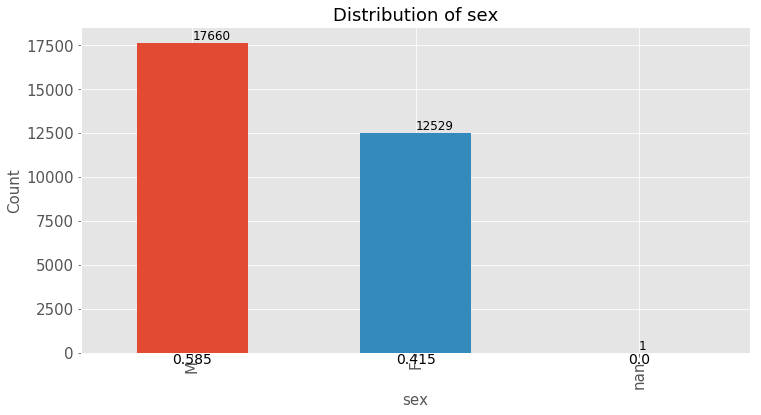

In [129]:
#sex
fraud_df.sex.value_counts()
get_bar_plot('sex', fraud_df)

In [135]:
sex_dummies = pd.get_dummies(fraud_df.sex)
sex_dummies
fraud_df['male'] = sex_dummies.M

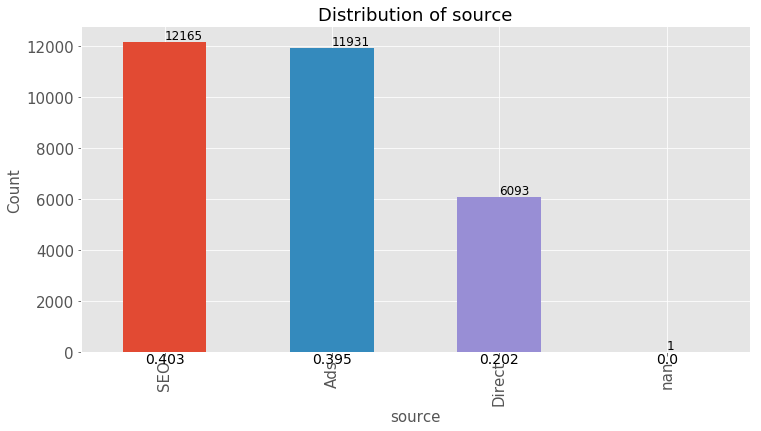

In [130]:
get_bar_plot('source', fraud_df)

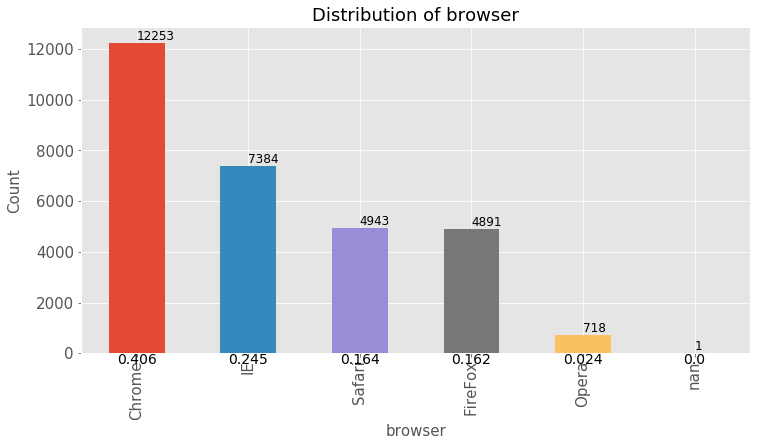

In [131]:
get_bar_plot('browser', fraud_df)

In [136]:
fraud_df = pd.get_dummies(fraud_df, columns = ['source', 'browser'])


In [137]:
#since get dummies, the last value can be represented by others, so drop the last column
fraud_df.drop('source_Direct', 'browser_Opera')
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,country,...,num_ip_shared,male,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,2015-02-24 22:55:00,2015-04-18 02:47:00,34.0,QVPSPJUOCKZAR,M,39.0,7.327584e+08,0.0,Japan,...,1.0,1,0,0,1,1,0,0,0,0
1,333320,2015-06-07 20:39:00,2015-06-08 01:38:00,16.0,EOGFQPIZPYXFZ,F,53.0,3.503114e+08,0.0,United States,...,1.0,0,1,0,0,1,0,0,0,0
2,1359,2015-01-01 18:52:00,2015-01-01 18:52:00,15.0,YSSKYOSJHPPLJ,M,53.0,2.621474e+09,1.0,United States,...,3.0,1,0,0,1,0,0,0,1,0
3,150084,2015-04-28 21:13:00,2015-05-04 13:54:00,44.0,ATGTXKYKUDUQN,M,41.0,3.840542e+09,0.0,Unknown,...,1.0,1,0,0,1,0,0,0,0,1
4,221365,2015-07-21 07:09:00,2015-09-09 18:40:00,39.0,NAUITBZFJKHWW,M,45.0,4.155831e+08,0.0,United States,...,1.0,1,1,0,0,0,0,0,0,1


In [ ]:
#save file
fraud_df.to_csv("fraud_cleaned_df.csv", index_column = 'user_id')

###  Build a model to predict whether an activity is fraudulent or not. Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.
Since this is a binary classification problem, I prefer to use tree based models, try decision tree first and then ensemble models such as random forest,adaboost, due to their high flexibility and acceptance capability of various kinds of features, high interpretability and most importantly, they will provide feature importance of the prediction problem, which is quite useful for providing solutions and recommendations.